<div style ="font-family:Trebuchet MS; background-color : #f8f0fa; border-left: 5px solid #1b4332; padding: 12px; border-radius: 50px 50px;">
    <h2 style="color: #1b4332; font-size: 48px; text-align: center;"><b> Dog-Cat Classification
 </b></h2>

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.image as mpimg
import cv2
import zipfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization,Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Images Exploration & Analysis

In [2]:
zip_file_path = '/kaggle/input/dogs-vs-cats/train.zip'
extract_folder = '/kaggle/working/pictures'


os.makedirs(extract_folder, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
print(os.listdir(extract_folder))


['train']


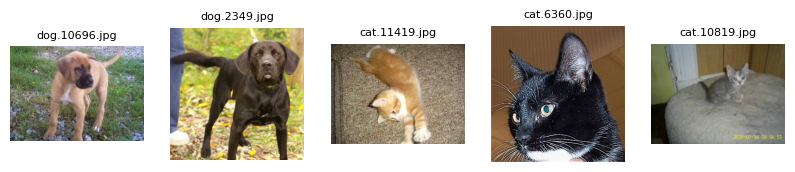

In [3]:
from PIL import Image

# Folder where the images are extracted
image_folder = '/kaggle/working/pictures/train'

# Get a list of image filenames
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Show sample images with their filenames
num_samples = min(5, len(image_files))  # Display up to 5 images

plt.figure(figsize=(10, 10))
for i, image_file in enumerate(image_files[:num_samples]):
    img_path = os.path.join(image_folder, image_file)
    img = Image.open(img_path)
    
    # Display the image
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(image_file, fontsize=8)
    plt.axis('off')

plt.show()


In [4]:
len(image_files)

25000

In [5]:
print(image_files[4])

cat.10819.jpg


In [6]:
image_files[0].split('.')[0]

'dog'

In [7]:
cats = 0
dogs = 0
for file in image_files :
    if file.split('.')[0] == 'dog' :
        dogs += 1
    else :
        cats +=1 

cats,dogs
    

(12500, 12500)

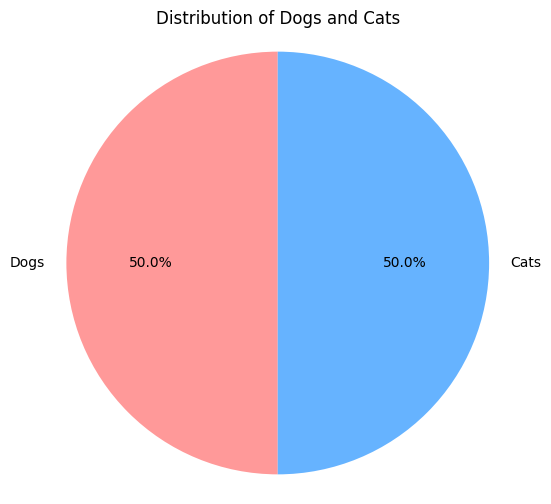

In [8]:
# Labels and data for the pie chart
labels = ['Dogs', 'Cats']
sizes = [dogs, cats]
colors = ['#ff9999','#66b3ff']  
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Distribution of Dogs and Cats')
plt.show()

**we have a balanced data**

In [9]:
del image_files
gc.collect()

13683

# Data Preprocessing

In [10]:
IMAGE_SIZE = (224,224)
def load_data(image_dir_train):
    def process_images(image_dir):
        images = []
        print("Loading images from {}".format(image_dir))
        for image_file in tqdm(os.listdir(image_dir)):
            img_path = os.path.join(image_dir, image_file)

            # Open and resize the image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)

            images.append(image)

        return np.array(images, dtype='float32')

    # Process train images and labels
    train_images = process_images(image_dir_train)
    labels = []
    for image_file in tqdm(os.listdir(image_dir_train)):
        image_class = image_file.split('.')[0]
        if image_class == 'dog' :
            labels.append(1)
        else :
            labels.append(0)
    train_labels = np.array(labels, dtype='int32')
    return train_images,train_labels 

train_images , train_labels = load_data(image_folder)
 

Loading images from /kaggle/working/pictures/train


100%|██████████| 25000/25000 [00:00<00:00, 890654.12it/s]


In [11]:
mymap = {
    0 : 'cat' ,
    1 : 'dog'
}

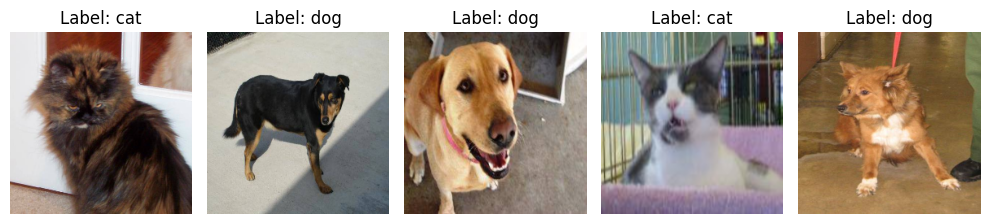

In [12]:
# Show the image (you must normalise it between 0 to 1)
def show_random(samples=5) :
    plt.figure(figsize=(10, 10))
    for i in range(samples) :
        r = random.randint(0, 25000)
        plt.subplot(1, samples, i + 1)
        plt.imshow(train_images[r] / 255.0)
        plt.title(f"Label: {mymap[train_labels[r]]}")
        plt.axis('off')
    plt.tight_layout()  # Adjust spacing to make sure images fit well
    plt.show()
show_random()

# CNN creation 

In [13]:
from sklearn.model_selection import train_test_split
train_images = train_images.astype('uint8')
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2,shuffle=True, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (20000, 224, 224, 3)
Validation data shape: (5000, 224, 224, 3)


In [14]:
from collections import Counter

print("Train labels distribution:", Counter(y_train))
print("Validation labels distribution:", Counter(y_val))


Train labels distribution: Counter({1: 10045, 0: 9955})
Validation labels distribution: Counter({0: 2545, 1: 2455})


In [15]:
del train_images,train_labels
gc.collect()

12320

In [16]:
model = Sequential([
    Conv2D(32, (3, 3),input_shape = (224,224,3) , activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3),  activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),  # Dropout to prevent overfitting
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,263,809 (73.49 MB)

 Trainable params: 19,263,809 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

**adding callback early stop**

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [19]:
BATCH_SIZE = 32
# datagen3 = ImageDataGenerator(
#     rescale=1.0/255.0,
# )
# train_generator3 = datagen3.flow(X_train, y_train, BATCH_SIZE,shuffle=True)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(X_val, y_val, BATCH_SIZE)

In [20]:
def train_model_with_generator(train_gen, batch_size=32, epochs=15):
    history = model.fit(
    train_gen,
    validation_data= val_generator,
    epochs=epochs,
    callbacks=[early_stopping],
        )

    
    return history

In [21]:
def plot_loss(history) :
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")


In [22]:
def plot_acc(history) :
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

In [23]:
# history =  train_model_with_generator(train_generator3)

In [24]:
# plot_acc(history)
# plot_loss(history)

In [25]:
# del train_generator3,datagen3,history
# import gc
# gc.collect()


# Data Augmentation

In [26]:
datagen2 = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,     # Randomly flip half the images horizontally
    zoom_range=[0.9, 1.1],    # Slightly conservative zoom
    brightness_range=[0.8, 1.2], # Randomly change brightness
    fill_mode='nearest'       # Fill in new pixels using reflection to avoid artifacts
)
train_generator2 = datagen2.flow(X_train, y_train, BATCH_SIZE)

In [27]:
history_image_augmentation = train_model_with_generator(train_generator2)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725872384.637909      72 service.cc:145] XLA service 0x7997e800d7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725872384.637980      72 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/625 ━━━━━━━━━━━━━━━━━━━━ 1:49:52 11s/step - accuracy: 0.5625 - loss: 0.6918

I0000 00:00:1725872390.607042      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 223s 340ms/step - accuracy: 0.6082 - loss: 0.6405 - val_accuracy: 0.7594 - val_loss: 0.4989
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 214s 338ms/step - accuracy: 0.7567 - loss: 0.4983 - val_accuracy: 0.7996 - val_loss: 0.4319
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 214s 338ms/step - accuracy: 0.7982 - loss: 0.4331 - val_accuracy: 0.8172 - val_loss: 0.3937
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 212s 336ms/step - accuracy: 0.8213 - loss: 0.3958 - val_accuracy: 0.8402 - val_loss: 0.3552
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 213s 337ms/step - accuracy: 0.8371 - loss: 0.3692 - val_accuracy: 0.8376 - val_loss: 0.3671
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 212s 336ms/step - accuracy: 0.8555 - loss: 0.3307 - val_accuracy: 0.8670 - val_loss: 0.3118
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 334ms/step - accuracy: 0.8628 - loss: 0.3081 - val_accuracy: 0.8542 - val_loss: 0.3243
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 212s 335ms/step - accuracy: 0.8705 - loss: 0.29

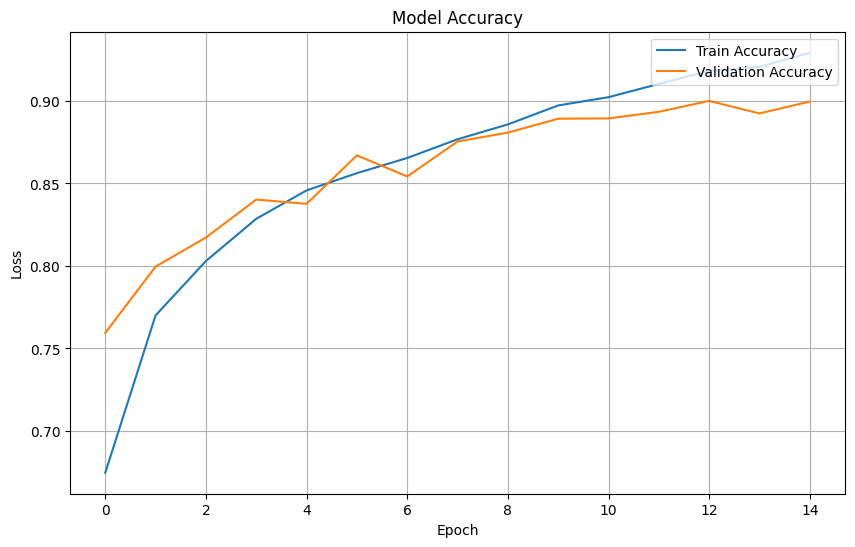

Validation Loss: 25.8727
Validation Accuracy: 0.8688


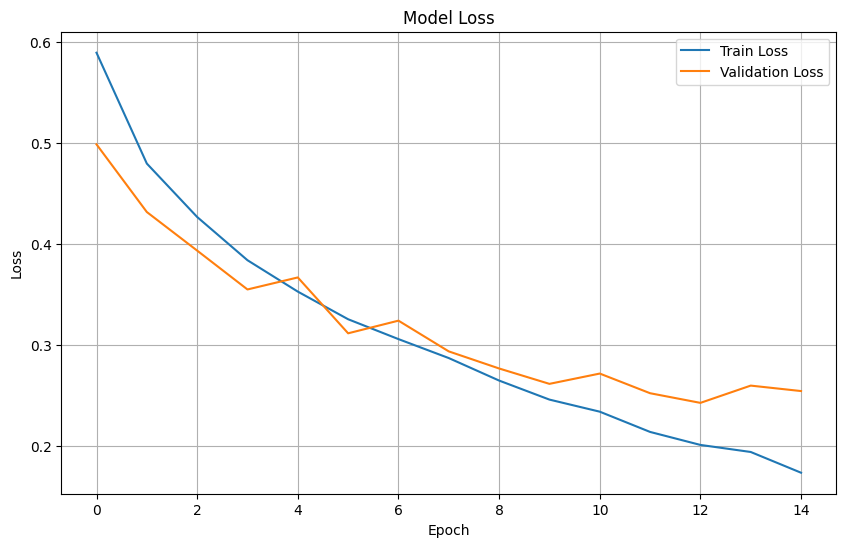

Validation Loss: 25.8727
Validation Accuracy: 0.8688


In [28]:
plot_acc(history_image_augmentation)
plot_loss(history_image_augmentation)

**we got better results with data augmentation**

# Make Prediction & Save the Model

In [29]:
# model.save('rafik_dog_cat_class.h5')

In [30]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/rafik_cat_dog/keras/default/1/rafik_dog_cat_class.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
[[0.8842224]]
Predicted class: [[1]]


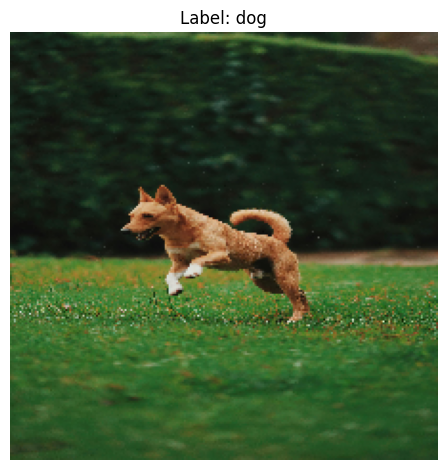

In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

mymap = {
    0 : 'cat' ,
    1 : 'dog'
}
model = load_model('/kaggle/input/rafik_cat_dog/keras/default/1/rafik_dog_cat_class.h5')


def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = img_array / 255.0  
    return img_array

img_array = preprocess_image('/kaggle/input/cat-dog-test/dog3.jpg')
predictions = model.predict(img_array)
print(predictions)
predicted_class = (predictions > 0.5).astype("int32")
print(f"Predicted class: {predicted_class}")
plt.imshow(np.squeeze(img_array, axis=0))
plt.title(f"Label: {mymap[predicted_class[0][0]]}")
plt.axis('off')
plt.tight_layout()  
plt.show()


# Submit result 

In [32]:
# sample_submission = pd.read_csv('/kaggle/input/dogs-vs-cats/sampleSubmission.csv')
# sample_submission

In [33]:
# zip_file_path = '/kaggle/input/dogs-vs-cats/test1.zip'
# extract_folder = '/kaggle/working/pictures'


# os.makedirs(extract_folder, exist_ok=True)

# # Extract the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder)
# print(os.listdir(extract_folder))


In [34]:
# from PIL import Image

# # Folder where the images are extracted
# image_folder = '/kaggle/working/pictures/test1'

# image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
# num_samples = min(5, len(image_files))

# plt.figure(figsize=(10, 10))
# for i, image_file in enumerate(image_files[:num_samples]):
#     img_path = os.path.join(image_folder, image_file)
#     img = Image.open(img_path)
    
#     # Display the image
#     plt.subplot(1, num_samples, i + 1)
#     plt.imshow(img)
#     plt.title(image_file, fontsize=8)
#     plt.axis('off')

# plt.show()


In [35]:
# IMAGE_SIZE = (224,224)
# def load_data(image_dir):
#     """
#     Load and preprocess the test images.
#     """
#     images = []
#     ids = []

#     print("Loading test images from {}".format(image_dir))
#     for image_file in tqdm(os.listdir(image_dir)):
#         img_path = os.path.join(image_dir, image_file)
        
#         # Load and preprocess the image
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, IMAGE_SIZE)

       
#         img = img / 255.0
        
#         images.append(img)
#         img_id = image_file.split('.')[0]  # Extract the image ID (without extension)
#         ids.append(img_id)

#     return np.array(images, dtype='float32'), ids

# # Load test images
# test_images, ids = load_data('/kaggle/working/pictures/test1')

# print("Making predictions on the test images...")
# predictions = model.predict(test_images)

# # Convert predictions to labels
# predicted_labels = (predictions > 0.5).astype('int32').flatten()


# submission_df = pd.DataFrame({
#     'id': ids,
#     'label': predicted_labels
# })
# submission_csv_path = 'submission.csv' 
# submission_df = submission_df.sort_values(by='id')
# submission_df.to_csv(submission_csv_path, index=False)
# print(f"Submission file saved: {submission_csv_path}")

In [36]:
# output_submission = pd.read_csv('/kaggle/working/submission.csv')
# output_submission